Computing the pearson similarity matrix...
Done computing similarity matrix.


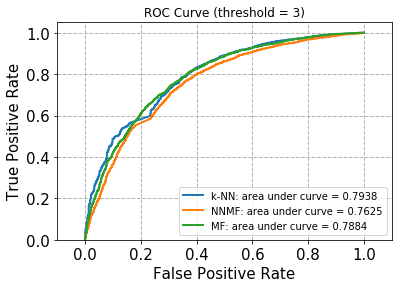

In [5]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, KNNWithMeans, accuracy
from surprise.model_selection import cross_validate, KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD

dataset = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating'])
ratings = pd.read_csv('ratings.csv')
reader = Reader(rating_scale=(0, 5))
threshold_val = [3]

def plot_roc_curve(y_test_knn, y_score_knn, y_test_nnmf, y_score_nnmf, y_test_mf, y_score_mf):
    fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test_knn, y_score_knn)
    fpr_nnmf, tpr_nnmf, thresholds_nnmf = roc_curve(y_test_nnmf, y_score_nnmf)
    fpr_mf, tpr_mf, thresholds_mf = roc_curve(y_test_mf, y_score_mf)
    fig, ax = plt.subplots()
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    roc_auc_nnmf = auc(fpr_nnmf, tpr_nnmf)
    roc_auc_mf = auc(fpr_mf, tpr_mf)
    ax.plot(fpr_knn, tpr_knn, lw = 2, label = 'k-NN: area under curve = %0.4f' % roc_auc_knn)
    ax.plot(fpr_nnmf, tpr_nnmf, lw = 2, label = 'NNMF: area under curve = %0.4f' % roc_auc_nnmf)
    ax.plot(fpr_mf, tpr_mf, lw = 2, label = 'MF: area under curve = %0.4f' % roc_auc_mf)
    ax.grid(color = '0.7', linestyle = '--', linewidth = 1)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize = 15)
    ax.set_ylabel('True Positive Rate', fontsize = 15)
    plt.title('ROC Curve (threshold = 3)')
    ax.legend(loc = "lower right")
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(15)
    plt.show()

# K-nn
data = Dataset.load_from_df(dataset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.1, random_state = 0)

label_true_test = []
for i in range(len(testset)):
    if testset[i][2] >= 3:
        label_true_test.append(1)
    else:
        label_true_test.append(0)

sim_options = {'name': 'pearson'}
algo = KNNWithMeans(k = 30, sim_options = sim_options)
algo.fit(trainset)
predictions = algo.test(testset)

prediction = []
for i in range(len(predictions)):
    prediction.append(predictions[i][3])

# NNMF
def NMF_bin_pre(ratings, ts, nmf_fac, thrd):
    reader = Reader(rating_scale=(0.0, 5.0))
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=ts, random_state = 0)
    algo = NMF(n_factors=nmf_fac, random_state=42)
    algo.fit(trainset)
    pre = algo.test(testset)

    true_rating = np.empty(len(pre))
    pred_rating = np.empty(len(pre))

    for i in range(len(pre)):
        true_rating[i] = pre[i][2]
        pred_rating[i] = pre[i][3]

    bi_rating = np.empty(len(pre))
    one_idx = true_rating >= thrd
    zero_idx = true_rating < thrd
    bi_rating[one_idx] = 1.0
    bi_rating[zero_idx] = 0.0
    
    return bi_rating, pred_rating
    
threshold = np.array([3])
for td in threshold:
    tar_nmf, pre_nmf = NMF_bin_pre(ratings, 0.1, 18, td)

# MF
def MF_bin_pre(ratings, ts, nmf_fac, thrd):
    reader = Reader(rating_scale=(0.0, 5.0))
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=ts, random_state = 0)
    algo = SVD(n_factors=nmf_fac, random_state=42)
    algo.fit(trainset)
    pre = algo.test(testset)

    true_rating = np.empty(len(pre))
    pred_rating = np.empty(len(pre))

    for i in range(len(pre)):
        true_rating[i] = pre[i][2]
        pred_rating[i] = pre[i][3]

    bi_rating = np.empty(len(pre))
    one_idx = true_rating >= thrd
    zero_idx = true_rating < thrd
    bi_rating[one_idx] = 1.0
    bi_rating[zero_idx] = 0.0
    
    return bi_rating, pred_rating

threshold = np.array([3])
for td in threshold:
    tar_mf, pre_mf = MF_bin_pre(ratings, 0.1, 6, td)

    
plot_roc_curve(label_true_test, prediction, tar_nmf, pre_nmf, tar_mf, pre_mf)